In [27]:
import torch
import torchmetrics
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn

In [2]:
from functools import partial

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [20]:
weights = torchvision.models.ConvNeXt_Base_Weights.IMAGENET1K_V1
model = torchvision.models.convnext_base(weights=weights).to(device)

In [5]:
DefaultFlowers102 = partial(torchvision.datasets.Flowers102, root="datasets",
                            transform=weights.transforms(), download=True)
train_set = DefaultFlowers102(split="train")
valid_set = DefaultFlowers102(split="val")
test_set = DefaultFlowers102(split="test")

In [7]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, batch_size = 32, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size = 32)
test_loader = DataLoader(test_set, batch_size = 32)

In [9]:
class_names = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia?', 'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium', 'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen', 'watercress', 'canna lily', 'hippeastrum', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily']

In [16]:
def plot_image(image):
    plt.imshow(image.permute(1,2,0))
    plt.axis("off")

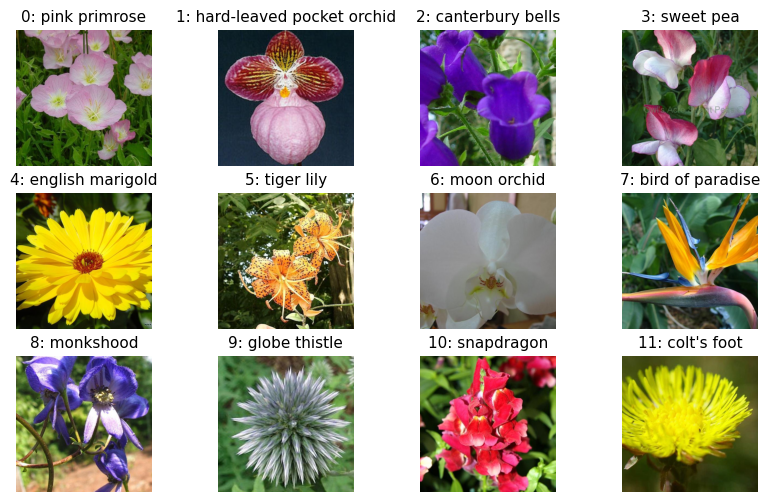

In [18]:
from torchvision.transforms import Compose, ToTensor, CenterCrop

transform = Compose([
    ToTensor(), CenterCrop(500)
])
flowers_to_display = DefaultFlowers102(split="train", transform=transform)
sample_flowers = sorted({y: img for img, y in flowers_to_display}.items())[:12]

plt.figure(figsize=(10,6))
for class_id, image in sample_flowers:
    if class_id == 12: break
    plt.subplot(3,4, class_id + 1)
    plot_image(image)
    plt.title(f"{class_id}: {class_names[class_id]}", fontsize=11)

plt.show()

In [ ]:
[name for name, child in model.named_children()]

['features', 'avgpool', 'classifier']

In [26]:
model.classifier[2]

Linear(in_features=1024, out_features=1000, bias=True)

In [28]:
n_classes = 102
model.classifier[2] = nn.Linear(1024, n_classes).to(device)

In [29]:
# Freezing the parameters of the model
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

In [30]:
def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            metric.update(y_pred, y_batch)
    return metric.compute()

def train(model, optimizer, loss_fn, metric, train_loader, valid_loader,
          n_epochs):
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.0
        metric.reset()
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metrics"].append(metric.compute().item())
        history["valid_metrics"].append(
            evaluate_tm(model, valid_loader, metric).item())
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")
    return history

In [31]:
n_epochs = 5
optimizer = torch.optim.AdamW(model.parameters())
xentropy = nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=102).to(device)

history = train(model, optimizer, xentropy, accuracy, train_loader, valid_loader, n_epochs)

Epoch 1/5, train loss: 4.2972, train metric: 0.1392, valid metric: 0.5578
Epoch 2/5, train loss: 2.9949, train metric: 0.7069, valid metric: 0.7402
Epoch 3/5, train loss: 2.0457, train metric: 0.8343, valid metric: 0.8333
Epoch 4/5, train loss: 1.3852, train metric: 0.9137, valid metric: 0.8441
Epoch 5/5, train loss: 0.9583, train metric: 0.9314, valid metric: 0.8755


In [ ]:
history = train(model, optimizer, xentropy, accuracy, train_loader, valid_loader, n_epochs)

Epoch 1/5, train loss: 0.6829, train metric: 0.9588, valid metric: 0.8686
Epoch 2/5, train loss: 0.5165, train metric: 0.9775, valid metric: 0.8824
Epoch 3/5, train loss: 0.4087, train metric: 0.9775, valid metric: 0.8863
Epoch 4/5, train loss: 0.3149, train metric: 0.9843, valid metric: 0.8882
Epoch 5/5, train loss: 0.2550, train metric: 0.9873, valid metric: 0.8961


In [33]:
for param in model.parameters():
    param.requires_grad = True

In [34]:
history = train(model, optimizer, xentropy, accuracy, train_loader, valid_loader, n_epochs)

OutOfMemoryError: CUDA out of memory. Tried to allocate 50.00 MiB. GPU 0 has a total capacity of 5.64 GiB of which 39.25 MiB is free. Process 15613 has 512.00 MiB memory in use. Including non-PyTorch memory, this process has 5.07 GiB memory in use. Of the allocated memory 4.84 GiB is allocated by PyTorch, and 120.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)